In [ ]:
cd/content/drive/MyDrive/Spotify_Music_Recommendation

[Errno 2] No such file or directory: '/content/drive/MyDrive/Spotify_Music_Recommendation'
/content


In [ ]:
!pip install transformers torch librosa --quiet

In [ ]:
from transformers import pipeline
import librosa
import numpy as np

In [ ]:
emotion_classifier = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base', return_all_scores=True)
def detect_emotion_from_text(text):
    results = emotion_classifier(text)[0]
    sorted_results = sorted(results, key=lambda x: x['score'], reverse=True)
    return sorted_results[0]['label'], sorted_results[0]['score']

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfcc, axis=1)


In [ ]:
from IPython import display
from IPython.display import Image


import os
print("Files in /content/ directory:")
for file in os.listdir('/content/'):
  print(file)

Files in /content/ directory:
.config
sample_data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier

In [13]:
artists_df = pd.read_csv('/content/spotify_artists.csv')
artists_df = artists_df.drop(['Unnamed: 0'], axis=1)
artists_df = artists_df.rename(columns = {'id':'artists_id'})
artists_df.head(2)

,artist_popularity,followers,genres,artists_id,name,track_id,track_name_prev,type
0,44,23230,"['sertanejo', 'sertanejo pop', 'sertanejo trad...",4mGnpjhqgx4RUdsIJiURdo,Juliano Cezar,0wmDmAILuW9e2aRttkl4aC,track_9,artist
1,22,313,[],1dLnVku4VQUOLswwDFvRc9,The Grenadines,4wqwj0gA8qPZKLl5WVqXml,track_30,artist


In [14]:
artists_df = artists_df.drop(['track_name_prev', 'type'], axis=1)

In [15]:
artists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56129 entries, 0 to 56128
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   artist_popularity  56129 non-null  int64 
 1   followers          56129 non-null  int64 
 2   genres             56129 non-null  object
 3   artists_id         56129 non-null  object
 4   name               56128 non-null  object
 5   track_id           56129 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.6+ MB


In [16]:
artists_df.head(2)

,artist_popularity,followers,genres,artists_id,name,track_id
0,44,23230,"['sertanejo', 'sertanejo pop', 'sertanejo trad...",4mGnpjhqgx4RUdsIJiURdo,Juliano Cezar,0wmDmAILuW9e2aRttkl4aC
1,22,313,[],1dLnVku4VQUOLswwDFvRc9,The Grenadines,4wqwj0gA8qPZKLl5WVqXml


In [19]:
albums_df = pd.read_csv('/content/spotify_albums.csv', engine='python')
albums_df = albums_df.drop(['Unnamed: 0'], axis=1)
albums_df = albums_df.rename(columns = {'id':'album_id'})
albums_df.head(2)

,album_type,artist_id,available_markets,external_urls,href,album_id,images,name,release_date,release_date_precision,total_tracks,track_id,track_name_prev,uri,type
0,single,3DiDSECUqqY1AuBP8qtaIa,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",{'spotify': 'https://open.spotify.com/album/1g...,https://api.spotify.com/v1/albums/1gAM7M4rBwEb...,1gAM7M4rBwEbSPeAQR2nx1,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",If I Ain't Got You EP,2019-02-08,day,6,2iejTMy9XZ8Gaae0aQ2yl0,track_32,spotify:album:1gAM7M4rBwEbSPeAQR2nx1,album
1,album,6s1pCNXcbdtQJlsnM1hRIA,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",{'spotify': 'https://open.spotify.com/album/4K...,https://api.spotify.com/v1/albums/4KfJZV7WfolY...,4KfJZV7WfolYlxBzOTo66s,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Shostakovich Symphony No.5 - Four Romances on ...,2019-03-01,day,8,1WQfghEjszJJ4H8MAWrQ2C,track_11,spotify:album:4KfJZV7WfolYlxBzOTo66s,album


In [20]:
albums_df = albums_df.drop(['available_markets', 'external_urls', 'href', 'images', 'uri', 'type'], axis=1)

In [21]:
albums_df.head(2)

,album_type,artist_id,album_id,name,release_date,release_date_precision,total_tracks,track_id,track_name_prev
0,single,3DiDSECUqqY1AuBP8qtaIa,1gAM7M4rBwEbSPeAQR2nx1,If I Ain't Got You EP,2019-02-08,day,6,2iejTMy9XZ8Gaae0aQ2yl0,track_32
1,album,6s1pCNXcbdtQJlsnM1hRIA,4KfJZV7WfolYlxBzOTo66s,Shostakovich Symphony No.5 - Four Romances on ...,2019-03-01,day,8,1WQfghEjszJJ4H8MAWrQ2C,track_11


In [22]:
tracks_df = pd.read_csv('/content/spotify_tracks.csv')
tracks_df = tracks_df.drop(['Unnamed: 0'], axis=1)
tracks_df = tracks_df.rename(columns = {'id':'track_id', 'popularity': 'track_popularity'})
tracks_df.head(2)

,acousticness,album_id,analysis_url,artists_id,available_markets,country,danceability,disc_number,duration_ms,energy,...,preview_url,speechiness,tempo,time_signature,track_href,track_name_prev,track_number,uri,valence,type
0,0.294,0D3QufeCudpQANOR7luqdr,https://api.spotify.com/v1/audio-analysis/5qlj...,['3mxJuHRn2ZWD5OofvJtDZY'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.698,1.0,235584.0,0.606,...,https://p.scdn.co/mp3-preview/1b05a902da3a251d...,0.0262,115.018,4.0,https://api.spotify.com/v1/tracks/5qljLQuKnNJf...,track_14,1.0,spotify:track:5qljLQuKnNJf4F4vfxQB0V,0.622,track
1,0.863,1bcqsH5UyTBzmh9YizdsBE,https://api.spotify.com/v1/audio-analysis/3VAX...,['4xWMewm6CYMstu0sPgd9jJ'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,656960.0,0.308,...,https://p.scdn.co/mp3-preview/d8140736a6131cb5...,0.9220,115.075,3.0,https://api.spotify.com/v1/tracks/3VAX2MJdmdqA...,track_3,3.0,spotify:track:3VAX2MJdmdqARLSU5hPMpm,0.589,track


In [23]:
tracks_df.artists_id = tracks_df.artists_id.str.strip("[]")
tracks_df.artists_id = tracks_df.artists_id.str.strip("'")

In [24]:
tracks_df.country.unique()

array(['BE', 'FI', 'AR', nan], dtype=object)

In [25]:
def country_func(x):
    if x == 'BE': return 1
    elif x == 'AR': return 2
    else: return 3

tracks_df.country = tracks_df.country.apply(country_func)

In [26]:
tracks_df['duration_ms'] = (tracks_df['duration_ms'] - tracks_df['duration_ms'].mean()) / tracks_df['duration_ms'].std()

In [27]:
tracks_df = tracks_df.drop(['album_id', 'analysis_url', 'disc_number', 'available_markets', 'href', 'mode', 'lyrics', 'playlist', 'name', 'preview_url', 'track_href', 'track_name_prev', 'uri', 'type'], axis=1)

In [28]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50806 entries, 0 to 50805
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      50806 non-null  float64
 1   artists_id        50805 non-null  object 
 2   country           50806 non-null  int64  
 3   danceability      50805 non-null  float64
 4   duration_ms       50805 non-null  float64
 5   energy            50805 non-null  float64
 6   track_id          50805 non-null  object 
 7   instrumentalness  50805 non-null  float64
 8   key               50805 non-null  float64
 9   liveness          50805 non-null  float64
 10  loudness          50805 non-null  float64
 11  track_popularity  50805 non-null  float64
 12  speechiness       50805 non-null  float64
 13  tempo             50805 non-null  float64
 14  time_signature    50805 non-null  float64
 15  track_number      50805 non-null  float64
 16  valence           50805 non-null  float6

In [29]:
tracks_df.head()

,acousticness,artists_id,country,danceability,duration_ms,energy,track_id,instrumentalness,key,liveness,loudness,track_popularity,speechiness,tempo,time_signature,track_number,valence
0,0.294,3mxJuHRn2ZWD5OofvJtDZY,1,0.698,-0.068371,0.606,5qljLQuKnNJf4F4vfxQB0V,0.000003,10.0,0.151,-7.447,28.0,0.0262,115.018,4.0,1.0,0.6220
1,0.863,4xWMewm6CYMstu0sPgd9jJ,1,0.719,2.060489,0.308,3VAX2MJdmdqARLSU5hPMpm,0.000000,6.0,0.253,-10.340,31.0,0.9220,115.075,3.0,3.0,0.5890
2,0.750,3hYaK5FF3YAglCj5HZgBnP,1,0.466,1.231328,0.931,1L3YAhsEMrGVvCgDXj2TYn,0.000000,4.0,0.938,-13.605,31.0,0.9440,79.565,4.0,4.0,0.0850
3,0.763,2KQsUB9DRBcJk17JWX1eXD,1,0.719,0.340824,0.126,6aCe9zzoZmCojX7bbgKKtf,0.000000,3.0,0.113,-20.254,14.0,0.9380,112.822,3.0,1.0,0.5330
4,0.770,3hYaK5FF3YAglCj5HZgBnP,1,0.460,1.564973,0.942,1Vo802A38tPFHmje1h91um,0.000000,7.0,0.917,-13.749,32.0,0.9430,81.260,4.0,2.0,0.0906


In [32]:
audio_features_df = pd.read_csv('/content/sample_data/lyrics_features.csv')
audio_features_df = audio_features_df.drop(['Unnamed: 0'], axis=1)
audio_features_df.head(2)

,mean_syllables_word,mean_words_sentence,n_sentences,n_words,sentence_similarity,track_id,vocabulary_wealth
0,-1.0,-1.00,-1,-1,-1.000000,5KIfHjHI5NIsPHNt58qua0,-1.00
1,1.1,5.65,31,326,0.043011,13keyz9ikBe6ZpRasw7l4X,0.45


In [33]:
audio_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94954 entries, 0 to 94953
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_syllables_word  94954 non-null  float64
 1   mean_words_sentence  94954 non-null  float64
 2   n_sentences          94954 non-null  int64  
 3   n_words              94954 non-null  int64  
 4   sentence_similarity  94954 non-null  float64
 5   track_id             94954 non-null  object 
 6   vocabulary_wealth    94954 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 5.1+ MB


In [35]:
lyrics_df = pd.read_csv('/content/sample_data/low_level_audio_features.csv')
lyrics_df = lyrics_df.drop(['Unnamed: 0'], axis=1)
lyrics_df.head(2)

,Chroma_1,Chroma_10,Chroma_11,Chroma_12,Chroma_2,Chroma_3,Chroma_4,Chroma_5,Chroma_6,Chroma_7,...,Tonnetz_4,Tonnetz_5,Tonnetz_6,ZCR,entropy_energy,spectral_bandwith,spectral_centroid,spectral_rollOff_max,spectral_rollOff_min,track_id
0,0.438296,0.472769,0.427441,0.436688,0.467697,0.493862,0.512244,0.568658,0.560524,0.513068,...,0.018434,-0.001759,-0.006392,0.067966,-89.113389,2564.247669,3558.400706,4508.506071,367.831109,19YEk4OVQZn3GfoxbpNrU6
1,0.596605,0.368288,0.285263,0.302211,0.905805,0.510909,0.221708,0.311248,0.491277,0.416469,...,0.046941,0.005665,-0.026928,0.047308,-127.945239,2370.181495,1499.689590,3647.394611,230.165275,6zJms3MX11Qu1IKF44LoRW


In [36]:
artists_df.loc[artists_df.followers == artists_df.followers.max()]

,artist_popularity,followers,genres,artists_id,name,track_id
55251,92,41561693,"['pop', 'uk pop']",6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,7qiZfU4dY1lWllzX7mPBI3


In [37]:
artists_df.loc[artists_df.artist_popularity == artists_df.artist_popularity.max()]

,artist_popularity,followers,genres,artists_id,name,track_id
42872,100,26309771,"['dance pop', 'pop', 'post-teen pop']",66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,1w1kzejjmiMhdWAOecgo4l


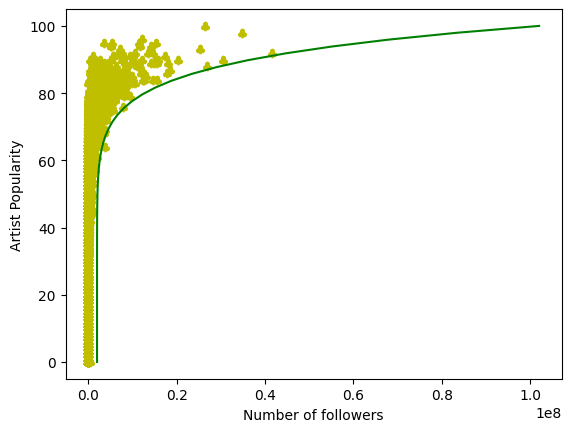

In [38]:
ax = plt.axes()
plt.scatter(artists_df.followers, artists_df.artist_popularity, c="y", marker=r'$\clubsuit$')
y = np.linspace(0, 100)
x = np.linspace(0, 40000000)
plt.plot(y**10/(10**12)+2*10**6, y, linestyle='solid', c="g")
plt.xlabel("Number of followers")
plt.ylabel("Artist Popularity")
plt.show()

In [40]:
albums_df["release_date"] = pd.to_datetime(albums_df["release_date"], errors='coerce', format='mixed')

In [45]:
albums_df["release_date"].min(), albums_df["release_date"].max()

(Timestamp('1886-01-01 00:00:00'), Timestamp('2019-04-26 00:00:00'))

In [46]:
albums_df['release_date'] = pd.DatetimeIndex(albums_df['release_date']).year

In [48]:
years = albums_df.release_date.unique()
years

array([2019, 2016, 2018, 1980, 2015, 1976, 2014, 2017, 1986, 2013, 1998,
       2006, 2000, 2005, 1996, 1985, 2007, 1977, 1979, 1999, 2003, 1982,
       1987, 2011, 1962, 1975, 2009, 2012, 1992, 1997, 2002, 2004, 1995,
       1972, 1994, 2008, 1971, 1990, 1991, 1988, 1989, 1993, 1970, 1984,
       1964, 2010, 2001, 1963, 1983, 1973, 1954, 1981, 1951, 1965, 1960,
       1974, 1959, 1958, 1968, 1969, 1961, 1938, 1967, 1946, 1978, 1945,
       1949, 1955, 1966, 1936, 1957, 1956, 1933, 1937, 1952, 1953, 1947,
       1950, 1886, 1934, 1935, 1939, 1928, 1926, 1948, 1942, 1944, 1923],
      dtype=int32)

In [49]:
years = albums_df.release_date.unique()
L = []
for year in years:
    L.append((albums_df.loc[albums_df.release_date == year]).count())
albums_counter = []
for i in range(len(L)):
    albums_counter.append(L[i].iloc[0])

In [50]:
data_dataframe = pd.DataFrame({'year': years, 'count': albums_counter })
data_dataframe.sort_values(by='year', ascending=False, na_position='first', inplace=True)
data_dataframe.head(2)

,year,count
0,2019,11125
2,2018,22050


/tmp/ipython-input-1409239338.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=data_dataframe, kind="bar", x="year", y="count", palette="spring_r")


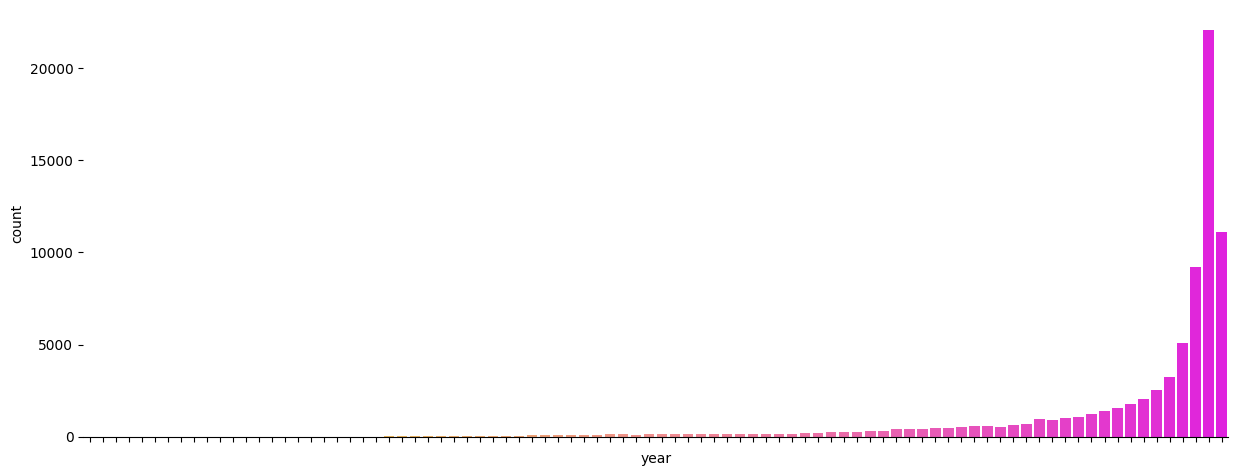

In [51]:
g = sns.catplot(data=data_dataframe, kind="bar", x="year", y="count", palette="spring_r")
g.fig.set_size_inches(15,5)
g.despine(left=True)
g.set(xticklabels=[])

In [52]:
key_dataframe = pd.DataFrame({'key': tracks_df.key, 'track_popularity_mean': tracks_df.track_popularity})
key_dataframe.groupby(['key'], as_index=True)\
    .aggregate({'track_popularity_mean': 'mean'})

,track_popularity_mean
key,
0.0,37.169012
1.0,37.814063
2.0,36.766465
3.0,37.113836
4.0,37.974731
5.0,37.108685
6.0,37.597362
7.0,37.199690
8.0,38.161792


/tmp/ipython-input-2661980228.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  m = sns.catplot(data=key_dataframe, kind="bar", x="key", y="track_popularity_mean", palette="spring_r")


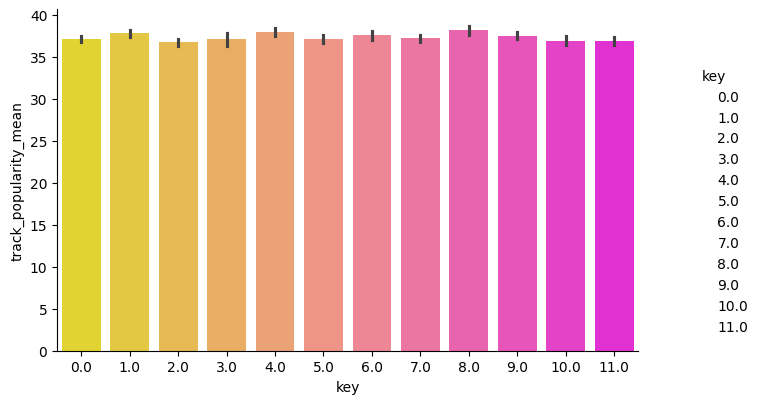

In [53]:
m = sns.catplot(data=key_dataframe, kind="bar", x="key", y="track_popularity_mean", palette="spring_r")
m.fig.set_size_inches(8,4)

In [54]:
((tracks_df.loc[tracks_df.key == 8]).loc[tracks_df.track_popularity == 80]).iloc[0:1]

,acousticness,artists_id,country,danceability,duration_ms,energy,track_id,instrumentalness,key,liveness,loudness,track_popularity,speechiness,tempo,time_signature,track_number,valence
39001,0.192,4A7HeXSd4HtQuf6IR5XZ1b,2,0.787,-0.166302,0.839,5z3vuYzS9UF6rD6TmBEdUf,0.0,8.0,0.0805,-3.594,80.0,0.217,154.086,4.0,1.0,0.799


In [55]:
tempo_1_dataframe = pd.DataFrame({'tempo': tracks_df.loc[tracks_df.track_popularity > 85].tempo, 'track_popularity': tracks_df.loc[tracks_df.track_popularity > 85].track_popularity})
tempo_2_dataframe = pd.DataFrame({'tempo': tracks_df.loc[tracks_df.track_popularity < 11].tempo, 'track_popularity': tracks_df.loc[tracks_df.track_popularity < 11].track_popularity})
pd.merge(tempo_1_dataframe.groupby(['track_popularity'], as_index=False).aggregate({'tempo': 'mean'}), tempo_2_dataframe.groupby(['track_popularity'], as_index=False).aggregate({'tempo': 'mean'}), left_index=True, right_index=True)

,track_popularity_x,tempo_x,track_popularity_y,tempo_y
0,87.0,120.013,0.0,74.214375


In [56]:
tracks_df.shape, artists_df.shape

((50806, 17), (56129, 6))

In [57]:
extended_tracks_df = pd.merge(tracks_df, artists_df[['artists_id', 'artist_popularity']], on='artists_id')
extended_tracks_df.shape

(38955, 18)

In [58]:
extended_tracks_df = pd.merge(tracks_df, artists_df[['artists_id', 'artist_popularity']], on='artists_id')
extended_tracks_df.head()

,acousticness,artists_id,country,danceability,duration_ms,energy,track_id,instrumentalness,key,liveness,loudness,track_popularity,speechiness,tempo,time_signature,track_number,valence,artist_popularity
0,0.294,3mxJuHRn2ZWD5OofvJtDZY,1,0.698,-0.068371,0.606,5qljLQuKnNJf4F4vfxQB0V,0.000003,10.0,0.151,-7.447,28.0,0.0262,115.018,4.0,1.0,0.6220,28
1,0.863,4xWMewm6CYMstu0sPgd9jJ,1,0.719,2.060489,0.308,3VAX2MJdmdqARLSU5hPMpm,0.000000,6.0,0.253,-10.340,31.0,0.9220,115.075,3.0,3.0,0.5890,36
2,0.750,3hYaK5FF3YAglCj5HZgBnP,1,0.466,1.231328,0.931,1L3YAhsEMrGVvCgDXj2TYn,0.000000,4.0,0.938,-13.605,31.0,0.9440,79.565,4.0,4.0,0.0850,41
3,0.763,2KQsUB9DRBcJk17JWX1eXD,1,0.719,0.340824,0.126,6aCe9zzoZmCojX7bbgKKtf,0.000000,3.0,0.113,-20.254,14.0,0.9380,112.822,3.0,1.0,0.5330,10
4,0.770,3hYaK5FF3YAglCj5HZgBnP,1,0.460,1.564973,0.942,1Vo802A38tPFHmje1h91um,0.000000,7.0,0.917,-13.749,32.0,0.9430,81.260,4.0,2.0,0.0906,41


Text(0.5, 1.0, 'Correlation matrix')

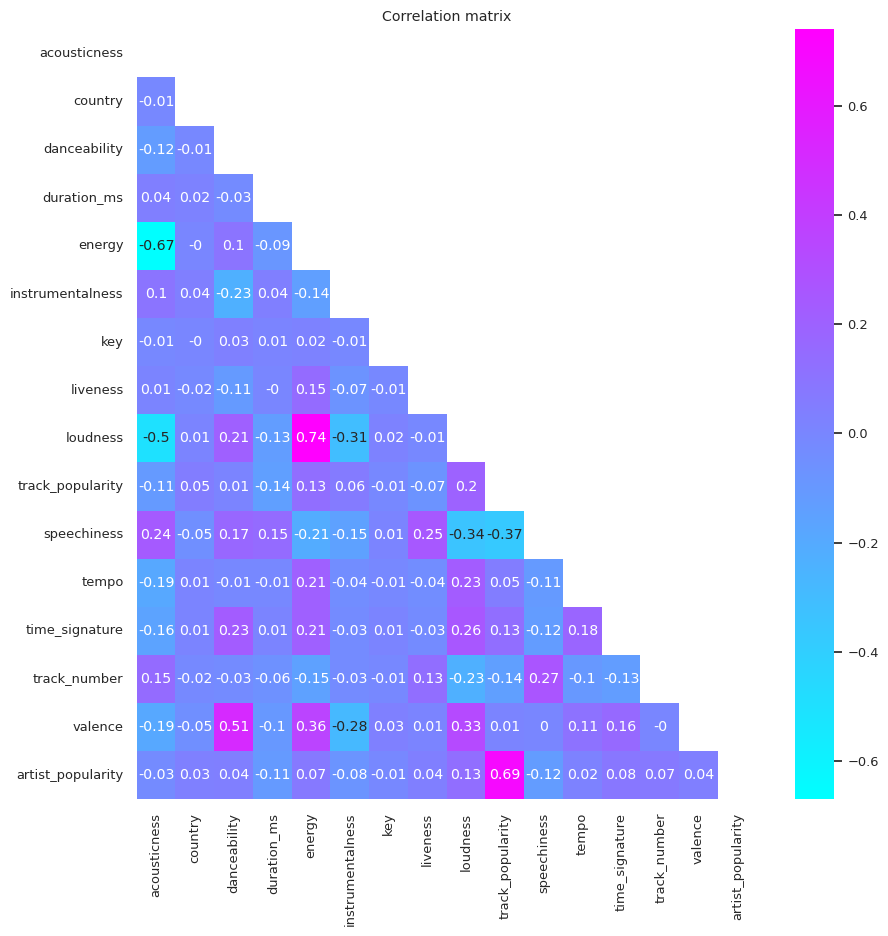

In [60]:
numeric_df = extended_tracks_df.select_dtypes(include=np.number)
corr=numeric_df.corr().round(2)

sns.set(font_scale=0.85)
plt.figure(figsize=(10, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='cool',mask=mask,cbar=True)
plt.title('Correlation matrix')

In [61]:
extended_tracks_df = extended_tracks_df.drop(['energy'], axis=1)

In [62]:
extended_tracks_df.track_popularity.max()

85.0

In [63]:
extended_tracks_df.head(2)

,acousticness,artists_id,country,danceability,duration_ms,track_id,instrumentalness,key,liveness,loudness,track_popularity,speechiness,tempo,time_signature,track_number,valence,artist_popularity
0,0.294,3mxJuHRn2ZWD5OofvJtDZY,1,0.698,-0.068371,5qljLQuKnNJf4F4vfxQB0V,0.000003,10.0,0.151,-7.447,28.0,0.0262,115.018,4.0,1.0,0.622,28
1,0.863,4xWMewm6CYMstu0sPgd9jJ,1,0.719,2.060489,3VAX2MJdmdqARLSU5hPMpm,0.000000,6.0,0.253,-10.340,31.0,0.9220,115.075,3.0,3.0,0.589,36


In [64]:
merged_tracks_df = pd.merge(extended_tracks_df, audio_features_df, on='track_id')
merged_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36676 entries, 0 to 36675
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   acousticness         36676 non-null  float64
 1   artists_id           36676 non-null  object 
 2   country              36676 non-null  int64  
 3   danceability         36676 non-null  float64
 4   duration_ms          36676 non-null  float64
 5   track_id             36676 non-null  object 
 6   instrumentalness     36676 non-null  float64
 7   key                  36676 non-null  float64
 8   liveness             36676 non-null  float64
 9   loudness             36676 non-null  float64
 10  track_popularity     36676 non-null  float64
 11  speechiness          36676 non-null  float64
 12  tempo                36676 non-null  float64
 13  time_signature       36676 non-null  float64
 14  track_number         36676 non-null  float64
 15  valence              36676 non-null 

In [65]:
merged_tracks_df.head(2)

,acousticness,artists_id,country,danceability,duration_ms,track_id,instrumentalness,key,liveness,loudness,...,time_signature,track_number,valence,artist_popularity,mean_syllables_word,mean_words_sentence,n_sentences,n_words,sentence_similarity,vocabulary_wealth
0,0.294,3mxJuHRn2ZWD5OofvJtDZY,1,0.698,-0.068371,5qljLQuKnNJf4F4vfxQB0V,0.000003,10.0,0.151,-7.447,...,4.0,1.0,0.622,28,1.39,3.13,39,208,0.02834,0.64
1,0.863,4xWMewm6CYMstu0sPgd9jJ,1,0.719,2.060489,3VAX2MJdmdqARLSU5hPMpm,0.000000,6.0,0.253,-10.340,...,3.0,3.0,0.589,36,1.44,25.56,106,5106,0.00018,0.57


In [66]:
merged_tracks_df.shape

(36676, 23)

In [67]:
tracks_df_test = merged_tracks_df.sample(n=10000, random_state=1)
tracks_df_train = merged_tracks_df.drop(tracks_df_test.index)
X_train = tracks_df_train.drop(columns = ['artists_id', 'track_id', 'track_popularity'])
y_train = tracks_df_train.track_popularity
X_test = tracks_df_test.drop(columns = ['artists_id', 'track_id', 'track_popularity'])
y_test = tracks_df_test.track_popularity

In [68]:
model = LinearRegression()
model.fit(X_train, y_train)
first_predictions = model.predict(X_test)
first_predictions
y_test
eps = first_predictions - y_test
eps

,track_popularity
19159,-3.285204
36486,16.061686
31189,6.685621
27704,-5.592952
32784,10.158558
...,...
22415,-15.630740
5160,-2.037253
23410,12.058708
1359,13.843414


In [69]:
from sklearn.metrics import mean_squared_error
print("Mean squared error: %.2f"
    % mean_squared_error(y_test, first_predictions))

Mean squared error: 103.72


In [70]:
counter = 0
for i in eps:
    if abs(i) > 20: counter+=1
counter

443